In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import gym

In [2]:
class Controller:
    '''Implements a feedback controller'''
    def __init__(self, environment):
        # approximate acceleration due to gravity on Earth
        self.g = 10
        # initializing pole length
        self.lp = environment.env.length
        # initializing pole mass
        self.mp = environment.env.masspole
        # initializing cart mass
        self.mk = environment.env.masscart
        # initializing total mass
        self.mt = environment.env.total_mass
        
    def state_controller(self):
        # state matrix
        a = self.g/(self.lp*(4.0/3 - self.mp/(self.mp+self.mk)))
        A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])
              
        # input matrix
        b = -1/(self.lp*(4.0/3 - self.mp/(self.mp+self.mk)))
        B = np.array([[0], [1/self.mt], [0], [b]])
        
        # R value (weight for the input)
        R = np.eye(1, dtype=int)
        # Q value (weight for the  state)
        Q = 5*np.eye(4, dtype=int)
        
        # solve the corresponding Ricatti equation
        P = linalg.solve_continuous_are(A, B, Q, R)
        
        # compute the optimal controller gain
        K = np.dot(np.linalg.inv(R), np.dot(B.T, P))

        return K
        
    def apply_state_controller(self, x):
        K = self.state_controller()
        # feedback controller
        u = -np.dot(K, x)   # u = -Kx
        if u > 0:
            return 1, u     # if force_dem > 0 -> move cart right
        else:
            return 0, u     # if force_dem <= 0 -> move cart left

/Users/glenn/miniforge3/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


Threshold reached after 200 iterations.


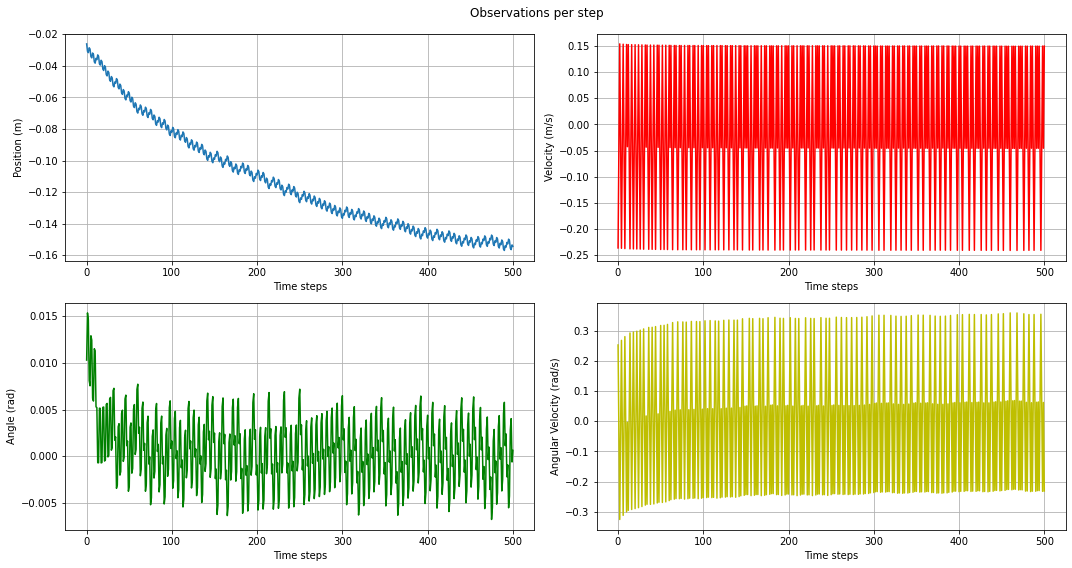

In [3]:
def run_experiment(rounds = 3000):
    '''Perform an experiment. Control the cart-pole system'''
    
    # initialize the environment
    env = gym.make('CartPole-v0')
    env.env.seed(2022)     # set the seed for reproducible results
    obs = env.reset()

    controller = Controller(env)

    position_list = []
    velocity_list = []
    angle_list = []
    angular_velocity_list = []
    steps = []
    flag = True
    
    for i in range(rounds):
        
        env.render()
        
        # get force direction (action) and force value (force)
        action, force = controller.apply_state_controller(obs)
        
        #absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
        abs_force = abs(float(np.clip(force, -10, 10)))
        
        # change magnitute of the applied force in CartPole
        env.env.force_mag = abs_force
        
        # enact corresponding action
        obs, reward, done, _ = env.step(action)
        
        # store state, time
        position_list.append(obs[0])
        velocity_list.append(obs[1])
        angle_list.append(obs[2])
        angular_velocity_list.append(obs[3])
        steps.append(i)
        
        if done and flag:
            print(f'Threshold reached after {i+1} iterations.')
            flag = False
        if i > 499:
            break
        
    env.close()
    
    # Plot results
    fig, ax = plt.subplots(2,2, figsize=(15,8))
    ax[0][0].plot(steps, position_list)
    ax[0][0].set_xlabel('Time steps')
    ax[0][0].set_ylabel('Position (m)')
    ax[0][0].grid()
    
    ax[0][1].plot(steps, velocity_list, 'r')
    ax[0][1].set_xlabel('Time steps')
    ax[0][1].set_ylabel('Velocity (m/s)')
    ax[0][1].grid()
    
    ax[1][0].plot(steps, angle_list, 'g')
    ax[1][0].set_xlabel('Time steps')
    ax[1][0].set_ylabel('Angle (rad)')
    ax[1][0].grid()
    
    ax[1][1].plot(steps, angular_velocity_list, 'y')
    ax[1][1].set_xlabel('Time steps')
    ax[1][1].set_ylabel('Angular Velocity (rad/s)')
    ax[1][1].grid()
    
    plt.suptitle('Observations per step')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__': 
    run_experiment()